# Setup

In [1]:
from sklearn.datasets import load_iris

import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')
sns.set()
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

Build 3D dataset

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X.shape

(60, 3)

# Implementation

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin, ClusterMixin

class MyPCA:
    def __init__(self, n_components=None,
                 verbose=0, random_state=42
                ):
        # initializing parameters used by the model
        self.n_components = n_components
        self.verbose = verbose
        self.random_state = random_state
        
        # Attributes
        # the principal components
        self.components_ = None
        # Equal to X.mean(axis=0)
        self.mean_ = None
        # Number of features in the training data
        self.n_features_ = None
        # Number of samples in the training data
        self.n_samples_ = None

    def fit(self, X):
        self.mean_ = X.mean(axis=0)
        # center the dataset
        X = X - self.mean_
        self.n_samples = m = X.shape[0]
        self.n_features = n = X.shape[1]
        
        # Covariance matrix, shape of (m, m)
        cov = np.cov(X.T)
        # Eigenvectors and eigenvalues
        # NOTE: The eigenvalue output by np.linalg.eig actually
        # has already taken into account the degree of freedom, 
        # so they have already been divided by (m - 1),
        # which results in the actual variance we want.
        variances, eigenvectors = np.linalg.eig(cov)
        eigenvalues = variances * (m - 1)
        # eigenvector of ith PC -> v[:, i]
        
        # Sort them by eigenvalues in descending order.
        # transpose the eigenvector to make it easier to index into
        eigenvectors = eigenvectors.T
        sorted_idxs = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[sorted_idxs]
        eigenvalues = eigenvalues[sorted_idxs]
        variances = variances[sorted_idxs]
        
#         # or just use np.linalg.svd(X) to simplify the steps above
#         #  where Vt is the transposed of eigenvectors we want
#         #  and s contains the eigenvalues
#         U, s, Vt = np.linalg.svd(X)
#         # s = singular values
#         # Vt = transposed of eigenvectors
#         eigenvectors = Vt

#         # singular values are the square root of eigenvalues,
#         #  so eigenvalues are just the square of singular values
#         eigenvalues = s ** 2
#         variances = eigenvalues / (len(X) - 1)
        
        # Choose k PCs
        self.components_ = eigenvectors[:self.n_components]
        self.explained_variance_ = variances[:self.n_components]
        self.explained_variance_ratio_ = self.explained_variance_ / np.sum(variances)
        self.singular_values_ = np.sqrt(eigenvalues)[:self.n_components]
    
    def transform(self, X):
        # Project the dataset onto the PCs
        X = X - self.mean_
        return np.dot(X, self.components_.T)
                
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [5]:
data = load_iris()
X = data.data
y = data.target
X.shape, y.shape

((150, 4), (150,))

In [6]:
# Project the data onto the 2 primary principal components
pca = MyPCA(2)
pca.fit(X)
X_projected = pca.transform(X)

print("Eigenvectors shape:", pca.components_.shape)
print("Shape of X:", X.shape)
print("Shape of transformed X:", X_projected.shape)

Eigenvectors shape: (2, 4)
Shape of X: (150, 4)
Shape of transformed X: (150, 2)


In [7]:
from sklearn.decomposition import PCA
sk_pca = PCA(2)
sk_X_projected = sk_pca.fit_transform(X)

In [8]:
print(pca.components_)
print(sk_pca.components_)

[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [-0.65658877 -0.73016143  0.17337266  0.07548102]]
[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]


In [9]:
print(pca.explained_variance_)
print(sk_pca.explained_variance_)

[4.22824171 0.24267075]
[4.22824171 0.24267075]


In [10]:
print(pca.explained_variance_ratio_)
print(sk_pca.explained_variance_ratio_)

[0.92461872 0.05306648]
[0.92461872 0.05306648]


In [11]:
print(pca.singular_values_)
print(sk_pca.singular_values_)

[25.09996044  6.01314738]
[25.09996044  6.01314738]


In [12]:
X_projected[:5]

array([[-2.68412563, -0.31939725],
       [-2.71414169,  0.17700123],
       [-2.88899057,  0.14494943],
       [-2.74534286,  0.31829898],
       [-2.72871654, -0.32675451]])

In [13]:
# some differences in terms of negative signs, not sure why
sk_X_projected[:5]

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451]])

# Visualizations

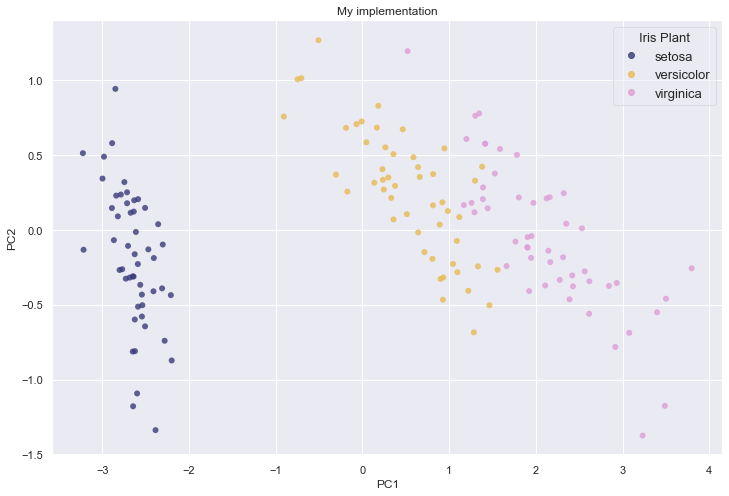

In [14]:
def plot_pca(X_projected, title=None):
    x1 = X_projected[:, 0]
    x2 = X_projected[:, 1]

    scatter = plt.scatter(
        x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("tab20b", 3)
    )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    handles, labels = scatter.legend_elements()
    labels = data.target_names
    legend = plt.legend(handles, labels, loc="upper right",
                        title="Iris Plant", fontsize=13,
                        title_fontsize=13, framealpha=0.5)
    plt.title(title)
    plt.show()

plot_pca(X_projected, title='My implementation')

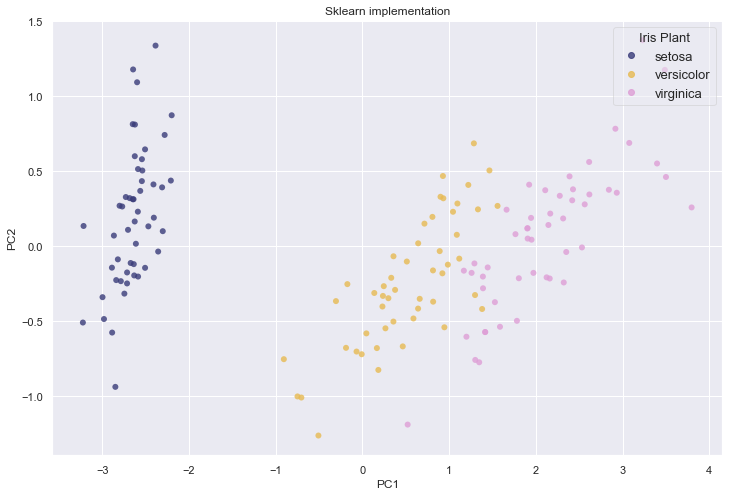

In [15]:
plot_pca(sk_X_projected, title='Sklearn implementation')

# Confusing problems between `np.linalg.svd` and `np.linalg.eig`

In [16]:
# first method
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
# s = singular values
# Vt = transposed of eigenvectors
eigenvectors_1 = Vt.T

# singular values are the square root of eigenvalues,
#  so eigenvalues are just the square of singular values
eigenvalues_1 = s ** 2
variances_1 = eigenvalues_1 / (len(X) - 1)

In [17]:
# comparing with sklearn, sklearn already picked the n_components
print(f"{variances_1 = }")
print(f"{sk_pca.explained_variance_ = }\n")
# some differences in the negative signs, not sure why
print(f"{Vt = }")
print(f"{sk_pca.components_ = }\n")
print(f"{s = }")
print(f"{sk_pca.singular_values_ = }")

variances_1 = array([4.22824171, 0.24267075, 0.0782095 , 0.02383509])
sk_pca.explained_variance_ = array([4.22824171, 0.24267075])

Vt = array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [-0.65658877, -0.73016143,  0.17337266,  0.07548102],
       [ 0.58202985, -0.59791083, -0.07623608, -0.54583143],
       [ 0.31548719, -0.3197231 , -0.47983899,  0.75365743]])
sk_pca.components_ = array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

s = array([25.09996044,  6.01314738,  3.41368064,  1.88452351])
sk_pca.singular_values_ = array([25.09996044,  6.01314738])


In [18]:
# second method (used in our implementation above)
cov = np.cov(X_centered.T)
# according to the documentation,
#  np.linalg.eig supposed to output eigenvalues,
#  but it actually outputs the variances directly.
variances_2, eigenvectors_2 = np.linalg.eig(cov)
eigenvalues_2 = variances_2 * (len(X) - 1)
# eigenvector of ith PC -> v[:, i]

# Sort them by eigenvalues in descending order.
sorted_idxs = np.argsort(eigenvalues_2)[::-1]
eigenvectors_2 = eigenvectors_2[:, sorted_idxs]
eigenvalues_2 = eigenvalues_2[sorted_idxs]

In [19]:
# the problem is np.linalg.eig actually outputs variances directly
#  instead of eigenvalues, this makes things very confusing because
#  the documentations said it's supposed to output eigenvalues instead of variances
print(eigenvalues_1 / (len(X) - 1))
print(variances_2)

[4.22824171 0.24267075 0.0782095  0.02383509]
[4.22824171 0.24267075 0.0782095  0.02383509]


In [20]:
eigenvectors_1, eigenvectors_2

(array([[ 0.36138659, -0.65658877,  0.58202985,  0.31548719],
        [-0.08452251, -0.73016143, -0.59791083, -0.3197231 ],
        [ 0.85667061,  0.17337266, -0.07623608, -0.47983899],
        [ 0.3582892 ,  0.07548102, -0.54583143,  0.75365743]]),
 array([[ 0.36138659, -0.65658877, -0.58202985,  0.31548719],
        [-0.08452251, -0.73016143,  0.59791083, -0.3197231 ],
        [ 0.85667061,  0.17337266,  0.07623608, -0.47983899],
        [ 0.3582892 ,  0.07548102,  0.54583143,  0.75365743]]))

In [21]:
eigenvalues_1, eigenvalues_2

(array([630.0080142 ,  36.15794144,  11.65321551,   3.55142885]),
 array([630.0080142 ,  36.15794144,  11.65321551,   3.55142885]))

**Conclusion**
- Eigenvalues can also be regarded as variance, and sometimes eigenvalues have already taken into account the number of samples by dividing themselves by `(m - 1)`, where `m` is the number of samples.